In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import C14preproc as prep
import pylab
import C14utils
import matplotlib
import socplot_lib as socplt
import isamcalc_lib as isam
import SOCtools as soc


isamcalc_lib.py:116: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  val[i, j] = np.nanmean(profile[i, ub:lb])
isamcalc_lib.py:125: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  val[i, j] = np.nanmean(profile[i, ub:lb])
/data/keeling/a/sshu3/anaconda2/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/data/keeling/a/sshu3/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:53: RuntimeWarning: invalid value encountered in less_equal
/data/keeling/a/sshu3/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:56: RuntimeWarning: invalid value encountered in less
/data/keeling/a/sshu3/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: invalid value encountered in less


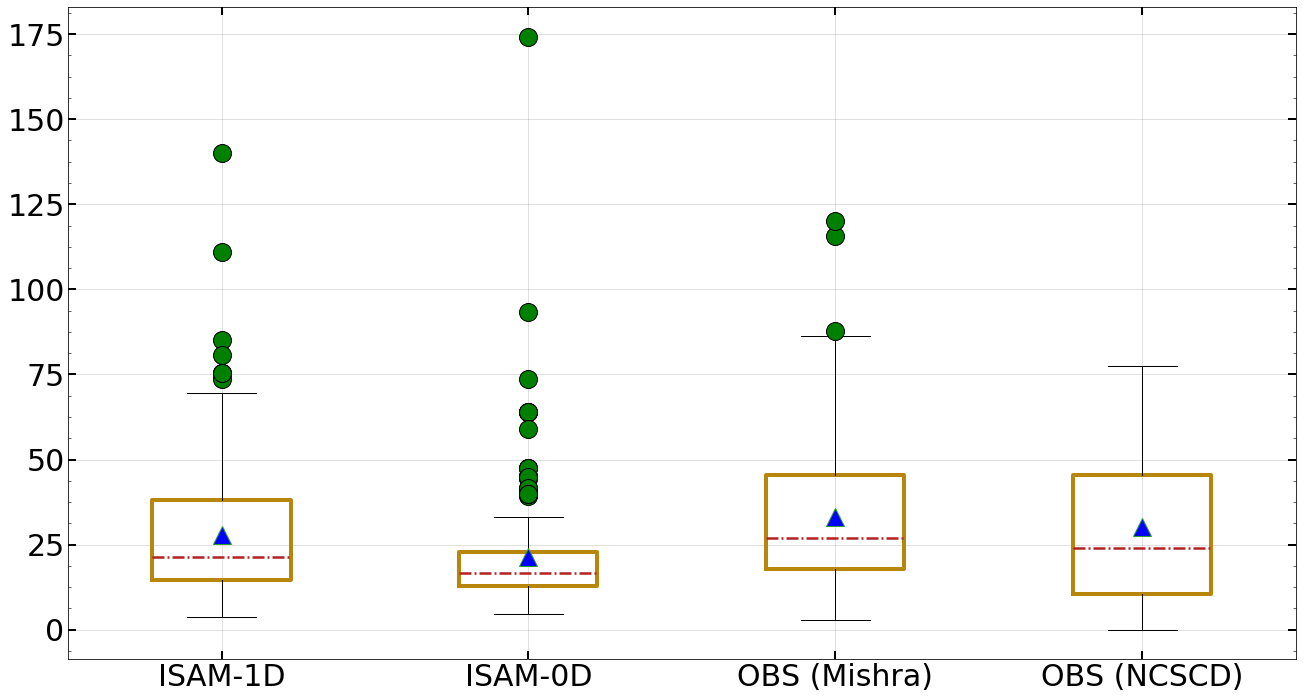

In [2]:
# =====================================================================
#  Plot the simulated SOC profiles for Umakant's samples
#  Compare with the observation also
# =====================================================================
fobs = "Mishra_soc_interp.csv"
fobs_pid = "sel_sites_carbon.csv"
fmod_pid = "caselist"
fmod_biome = "pftlist"
fmod = "isam_um_soc.dat"
fmod0 = "isam_0d_soc.dat"
fncscd = "NCSCD_extracted.csv"
#fmod = "Mishra_soc_mod.dat"
fhistel_filter = "nohistel"

# Read in obs
# 354 samples in total
obs = pd.read_csv(fobs, encoding='iso-8859-1', index_col=0)
obs_pid = pd.read_csv(fobs_pid, encoding='iso-8859-1', index_col=0)
obs_profid = obs_pid.index.unique()
obs.index = obs_profid
# Read in the model output
# 354 samples in total
mod = pd.read_csv(fmod, delim_whitespace=True, header=None)
mod_pid = pd.read_csv(fmod_pid, header=None, index_col=0)
mod_biome = pd.read_csv(fmod_biome, header=None, index_col=0)
mod.index = mod_pid.index
# Read in the 0d model output
# 354 samples in total
mod0 = pd.read_csv(fmod0, delim_whitespace=True, header=None)
mod0.index = mod_pid.index
# Read in the NCSCD data product!
#354 samples in toital
ncscd_data = pd.read_csv(fncscd)
ncscd_data.index = obs_profid
ncscd_data.NCSCDv2_Ci = ncscd_data.NCSCDv2_Ci/10.   # From hgC/m2 to kgC/m2

# Read in the histel filter
histel_f = pd.read_csv(fhistel_filter, header=None, index_col=0)

sel_profid = mod_pid.index
obs_sel = obs.loc[sel_profid]

# Filter out the histel before the comparison
obs_sel.loc[histel_f.index] = -9999.
mod.loc[histel_f.index] = -9999.
mod0.loc[histel_f.index] = -9999.
ncscd_data.loc[histel_f.index] = -9999.

# Convert the interpolated SOC into ISAM depth
z, dz, zsoih = isam.get_isam_soildp(10)
# obs_as_isam = isam.mean_by_depth(10, zsoih, sel_profid.size, obs_sel.as_matrix())
obs_as_isam = isam.mean_by_depth_sep8(10, zsoih, sel_profid.size, obs_sel.as_matrix())
obs_as_isam[obs_as_isam<=0]=float('nan')
# Unit convert: g/cm3 -> kg/m3
obs_isam = obs_as_isam * 1000.
obs_isam[obs_isam<0.] = float("nan")
# Aggregated SOC density to SOC stock profile till 1m
obs_agg_prof = soc.aggre_profden_to_profstock(10, dz, obs_isam)
# obs_agg = soc.aggre_profden_to_stock(7, dz, obs_isam)
obs_agg = soc.aggre_profden_to_stock_1m(zsoih, dz, obs_isam)

mod_isam = mod.as_matrix()/dz
mod_isam[mod_isam<0.] = float("nan")
mod_agg_prof = soc.aggre_profden_to_profstock(10, dz, mod_isam)
# mod_agg = soc.aggre_profden_to_stock(7, dz, mod_isam)
mod_agg = soc.aggre_profden_to_stock_1m(zsoih, dz, mod_isam)

# Filter out the observation if model did not calculate
obs_agg[np.isnan(mod_agg)] = float("nan")
obs_agg_prof[np.isnan(mod_agg_prof)] = float("nan")

# Screen out NCSCD observations with the written \
ncscd = ncscd_data.NCSCDv2_Ci.as_matrix()
ncscd[np.isnan(mod_agg)] = float("nan")

mod0[mod0<0] = float("nan")
mod0_agg = mod0.as_matrix().reshape(354)

# Prepare figures
# 1) Barplot of the comparison of the total SOC stock 
# do not separate into different biomes (all in one)
obs_agg_avg = np.nanmean(obs_agg)
mod_agg_avg = np.nanmean(mod_agg)
mod0_avg = np.nanmean(mod0)
# Boxplot of the total SOC in the first 1m
# Shijie: Shall filter out peat before plotting!
data_for_bplot = [mod_agg[~np.isnan(mod_agg)], mod0_agg[~np.isnan(mod0_agg)], obs_agg[~np.isnan(obs_agg)], ncscd[~np.isnan(ncscd)]]

# multiple box plots on one figure
plt.figure(figsize=(22,12))
boxprops = dict(linestyle='-', linewidth=4, color='darkgoldenrod')
flierprops = dict(marker='o', markerfacecolor='green', markersize=18,
                  linestyle='none')
medianprops = dict(linestyle='-.', linewidth=2.5, color='firebrick')
meanprops = dict(marker='^', markerfacecolor='blue', markersize=18,
                  linestyle='none')
#meanlineprops = dict(linestyle='--', linewidth=2.5, color='purple')

plt.boxplot(data_for_bplot, boxprops=boxprops, flierprops=flierprops, \
           medianprops=medianprops, meanprops=meanprops, showmeans=True) #, meanlineprops=meanlineprops)
plt.xticks([1, 2, 3, 4], ['ISAM-1D', 'ISAM-0D', 'OBS (Mishra)', 'OBS (NCSCD)'], fontsize=30)
plt.yticks([0, 25, 50, 75, 100, 125, 150, 175], fontsize=30)
#plt.xlim((0, 9))
#plt.ylim((-500, 500))
plt.grid(color='gray', which='major', axis='both', alpha=0.3)
plt.minorticks_on()
plt.tick_params(axis='x',which='major',direction='in',length=8, width=2)
plt.tick_params(axis='x',which='minor',bottom='off')
plt.tick_params(axis='y',which='major',direction='in',length=8, width=2)
plt.tick_params(axis='y',which='minor',direction='in',length=3)
plt.tick_params(axis="x", which="major", top=True)
plt.tick_params(axis="y", which="both", right=True)
plt.show()
#plt.savefig('./figures/fig5/fig5a.png')



In [ ]:
# =====================================================================
# Optional
# =====================================================================
# 2) The comparison of the accumulated SOC profile
obs_aggprof_avg = np.nanmean(obs_agg_prof, axis=0)
mod_aggprof_avg = np.nanmean(mod_agg_prof, axis=0)
obs_aggprof_std = np.nanstd(obs_isam*dz, axis=0)
mod_aggprof_std = np.nanstd(mod_isam*dz, axis=0)
obs_aggprof_avg[9] = float("nan")
obs_aggprof_std[9] = float("nan")
mod_aggprof_std[:] = 0.
obs_aggprof_std = obs_aggprof_std #/np.sqrt(146.)  # 146 is the sample size
mod_aggprof_std = mod_aggprof_std #/np.sqrt(146.)  # 146 is the sample size

soildp = z[0:8]*100
#tit = "Accumulated SOC profile"
tit = ""
path = "./figures/fig5/Um_SOC_profile.png"

kwargs = {'Xobs': obs_aggprof_avg[0:8], 'Yobs': soildp, 'Xmod': mod_aggprof_avg[0:8], 'Ymod': soildp,
          'Xobs_std': obs_aggprof_std[0:8], 'Xmod_std': mod_aggprof_std[0:8], 'tit': ' ', 'path': path}

# Figure with std as error bar
status = socplt.plot_obsvsmod_with_errbar(**kwargs)


In [ ]:
# =====================================================================
# Optional
# =====================================================================
# 3) The comparison of the accumulated SOC profile by different biomes
# Pick one biome and run the code once at a time
# 5 biomes in total:
# 7 - grassland
# 8 - shrub
# 9 - tundra
# 5 - boreal evergreen
# 20 - boreal deciduous
obs_agg_prof_pft = obs_agg_prof[mod_biome.index == 7]
mod_agg_prof_pft = 1.7*mod_agg_prof[mod_biome.index == 7]
obs_aggprof_avg = np.nanmean(obs_agg_prof_pft, axis=0)
mod_aggprof_avg = np.nanmean(mod_agg_prof_pft, axis=0)
obs_aggprof_std = np.nanstd(obs_isam[mod_biome.index == 7]*dz, axis=0)
mod_aggprof_std = np.nanstd(mod_isam[mod_biome.index == 7]*dz, axis=0)
obs_aggprof_avg[9] = float("nan")
obs_aggprof_std[9] = float("nan")
mod_aggprof_std[:] = 0.
obs_aggprof_std = obs_aggprof_std #/np.sqrt(146.)  # 146 is the sample size
mod_aggprof_std = mod_aggprof_std #/np.sqrt(146.)  # 146 is the sample size

soildp = z[0:8]*100
#tit = "Accumulated SOC profile"
tit = ""
path = "./SOC_grassland_profile.png"

status = socplt.plot_obsvsmod_with_errbar(obs_aggprof_avg[0:8], soildp, mod_aggprof_avg[0:8], soildp, obs_aggprof_std[0:8], mod_aggprof_std[0:8], tit, path)


In [ ]:
# =====================================================================
#  Plot the simulated 1-m integrated D14C profiles for Umakant's samples
#  Compare with the others?
# =====================================================================
# ==========================================
## Recalculate the Tau for 1-D ISAM model
# ==========================================
fmod_pid = "caselist"
fmod_biome = "pftlist"
fmod = "isam_um_dc14.dat"
fmod_soc = "isam_um_soc.dat"
fhistel_filter = "nohistel"

# Read in D14C from observation
data = pd.read_csv(fmod, delim_whitespace=True, header=None)
pid = pd.read_csv(fmod_pid, header=None, index_col=0)
data.index = pid.index

# Read in the SOC profile
dsoc = pd.read_csv(fmod_soc, delim_whitespace=True, header=None)
dsoc.index = pid.index
soc = dsoc.as_matrix()
frac = soc * np.float("nan")
for i in np.arange(0,7):
    frac[:,i] = soc[:,i]/np.sum(soc[:,0:7], axis=1)

# Filter the Histel data
histel_f = pd.read_csv(fhistel_filter, header=None, index_col=0)
data.loc[histel_f.index] = -9999.

# Assign Nan value for the all the data with -9999.
data[data<-1200.] = float("nan")
# Get the C-weighted D14
d14c = np.nansum(frac * data, axis=1)
d14c[d14c==0.]=np.float("nan")

# Calculate tau
z, dz, zsoih = isam.get_isam_soildp(10)
# First get the C-weighted mean D14C for each profile
 
sampleyr = 2005 * np.ones(len(d14c))

tau, cost = C14utils.cal_tau(d14c, sampleyr, 1, 0)
tau[tau==2.00000000e+03] = np.float("nan")
data['tau'] = pd.Series(tau[:,0], index=data.index)
data.nodedepth = z*100
#tau=np.loadtxt("isam_um_tau.csv")
ttt=tau.reshape(354)

# ==========================================
## Recalculate the Tau for 0-D ISAM model
# ==========================================
fmod_pid = "caselist"
fmod_biome = "pftlist"
fmod = "isam_0d_d14c.dat"
fmod_soc = "isam_0d_soc.dat"
fhistel_filter = "nohistel"

# Read in D14C from observation
data = pd.read_csv(fmod, delim_whitespace=True, header=None)
pid = pd.read_csv(fmod_pid, header=None, index_col=0)
data.index = pid.index

# Read in the SOC profile
dsoc = pd.read_csv(fmod_soc, delim_whitespace=True, header=None)
dsoc.index = pid.index
soc = dsoc.as_matrix()
frac = 1.

# Filter the Histel data
histel_f = pd.read_csv(fhistel_filter, header=None, index_col=0)
data.loc[histel_f.index] = -9999.

# Assign Nan value for the all the data with -9999.
data[data<-1200.] = float("nan")
# Get the C-weighted D14
d14c = np.nansum(frac * data, axis=1)
d14c[d14c==0.]=np.float("nan")

# Calculate tau
z, dz, zsoih = isam.get_isam_soildp(10)
# First get the C-weighted mean D14C for each profile
 
sampleyr = 2010 * np.ones(len(d14c[0:354]))

tau0, cost = C14utils.cal_tau(d14c[0:354], sampleyr, 1, 0)
tau0[tau0==2.00000000e+03] = np.float("nan")
data['tau'] = pd.Series(tau0[:,0], index=data.index)
data.nodedepth = z*100
ttt0=tau0.reshape(354)

# ==========================================
## Site level estimations of Tau
# ==========================================
# Schadel et al., 2014
tau_org = 98.95
tau_min = 2350.443
# Assume the same fraction of organic vs mineral
tau_comb = 0.5*tau_org + 0.5*tau_min 
ttt_o = [tau_org, tau_min, tau_comb]

# Knoblauch et al., 2013
tau_a = 0.26*0.0222+170.3*0.9778
tau_ana = 0.21*0.0064+2652*0.9936
# Assume the same fraction of organic vs mineral
tau_comb = 0.5*tau_a + 0.5*tau_ana 
ttt_o2 = [tau_a, tau_ana, tau_comb]

# Trumbore and Harden, 1997

tau_s1 = 62.24605043
tau_s2 = 1017.085308
tau_s3 = 1068.201909
#tau_s4 = 2485.23
#ttt_o3 = [tau_s1, tau_s2, tau_s3, tau_s4]
ttt_o3 = [tau_s1, tau_s2, tau_s3]

lit_all = ttt_o + ttt_o2 + ttt_o3
mean_lit = np.nanmean(lit_all)


data_bplot = [ttt[~np.isnan(ttt)], ttt0[~np.isnan(ttt0)], ttt_o, ttt_o2, ttt_o3]

# Plot boxplot for tau
plt.figure(figsize=(16,10))
boxprops = dict(linestyle='-', linewidth=4, color='darkgoldenrod')
flierprops = dict(marker='o', markerfacecolor='green', markersize=18,
                  linestyle='none')
medianprops = dict(linestyle='-.', linewidth=2.5, color='firebrick')
meanprops = dict(marker='^', markerfacecolor='blue', markersize=18,
                  linestyle='none')
plt.boxplot(data_bplot,  boxprops=boxprops, flierprops=flierprops, \
           medianprops=medianprops, meanprops=meanprops, showmeans=True)
plt.xticks([1,2,3,4,5], ['ISAM-1D', 'ISAM-0D', 'Schadel et al., 2014', 'Knoblauch et al., 2013', 'Trumbore and Harden, 1997'], fontsize=30)
#plt.boxplot(data_bplot,  boxprops=boxprops, flierprops=flierprops, \
#           medianprops=medianprops, meanprops=meanprops, showmeans=True)
# Add the line representing the mean value
plt.grid(color='gray', which='major', axis='both', alpha=0.3)
plt.minorticks_on()
plt.tick_params(axis='x',which='major',direction='in',length=8, width=2)
plt.tick_params(axis='x',which='minor',bottom='off')
plt.tick_params(axis='y',which='major',direction='in',length=8, width=2)
plt.tick_params(axis='y',which='minor',direction='in',length=3)
plt.tick_params(axis="x", which="major", top=True)
plt.tick_params(axis="y", which="both", right=True)
plt.axhline(mean_lit, color="gray", linestyle= 'dashdot')
plt.yticks([0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000], fontsize=30)
plt.show()
#plt.savefig('./figures/fig5/fig5b.png')


In [ ]:
# Now check the turnover by different biome!
# Pick one biome and run the code once at a time
# 5 biomes in total:
# 7 - grassland
# 8 - shrub
# 9 - tundra
# 5 - boreal evergreen
# 20 - boreal deciduous
fmod_biome = "pftlist"
biome = pd.read_csv(fmod_biome, header=None, index_col=0)
tt1 = ttt[biome.index == 5]
data_bplot = tt1[~np.isnan(tt1)]

plt.figure()
plt.boxplot(data_bplot)
plt.xticks([1], ['Boreal turnover'])
plt.savefig('tau_ISAM.png')

